In [1]:
import compute_charge_dist as fz
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

import PeHeat_Functions as peh
import parametric_fz as fzpar
import dust_size_dist as sizedist

import yt
from yt.units import pc, kpc, second, Kelvin, gram, erg, cm

import MCMCFit as mcmc

%matplotlib inline

microntocm    = 1.0e-4
cmtomicron    = 1.0e4
AAtocm        = 1.0e-8
cmtoAA        = 1.0e8
microntoAA    = 1.0e4
AAtomicron    = 1.0e-4
ergtoeV       = 6.242e11
eVtoerg       = 1.602e-12

hplanck       = 4.135667662e-15 # eV s
clight        = 2.99792458e10   # cm s-1

Loading the library to compute the charge distribution of dust grains.


In [2]:
# Define some constant parameters to be used.
mp      = 1.6726e-24  * gram # g
mH      = 1.6733e-24  * gram
mC      = 12.011*mH
#mu      = 1.2924
kb      = 1.3806e-16  *erg / Kelvin # erg K-1
GNewton = 6.6743e-8   * cm**3 / (gram * second**2 )# cm3 g-1 s-2
Msun    = 1.9884e33   * gram
#mm      = mu*mp

ppc = 3.0856776e18

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# Create a derived field.
# Hydrogen number density
def numdensH(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    return nH

# Molecular Hydrogen number density
def numdensH2(field, data): 
    nH2 = data["dens"]*(data["ih2 "])/(1.4*mH)
    return nH2

# Carbon number density
def numdensC(field, data): 
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    return nC

# electron number density
def numdense(field, data): 
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    return ne

# Ionized hydrogen fraction
def xHp(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xHp = data["dens"]*data["ihp "]/(1.4*mH)
    xHp = xHp / nH
    return xHp

# Molecular hydrogen fraction
def xH2(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xH2 = data["dens"]*data["ih2 "]/(1.4*mH)
    xH2 = xH2 / nH
    return xH2

# Ionized carbon fraction
def xCp(field, data): 
    nC  = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    xCp = data["dens"]*data["icp "]/(1.4*mC) / nC
    return xCp

# electron fraction
def xe(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    xe = ne / (nH + nC)
    return xe

# electron fraction
#def GG(field, data): 
#    G = fz.get_G(data["cdto"], 1.68)
#    return G


yt.add_field('nH', function=numdensH,  units="1/cm**3", force_override=True)
yt.add_field('nH2',function=numdensH2, units="1/cm**3", force_override=True)
yt.add_field('nC', function=numdensC,  units="1/cm**3", force_override=True)
yt.add_field('ne', function=numdense,  units="1/cm**3", force_override=True)
yt.add_field('xHp', function=xHp,      units="dimensionless", force_override=True)
yt.add_field('xH2', function=xH2,      units="dimensionless", force_override=True)
yt.add_field('xCp', function=xCp,      units="dimensionless", force_override=True)
yt.add_field('xe', function=xe,        units="dimensionless", force_override=True)
#yt.add_field('G',  function=GG,        units="dimensionless", force_override=True)

/Users/juan/anaconda/lib/python2.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


In [3]:
# Input variables.
#data_dir   = "/home/jcibanezm/codes/run/Silcc/CF_Prabesh"
data_dir   = "/Users/juan/codes/run/Silcc/CF_Prabesh"
filename   = data_dir + "/NL99_R8_cf_hdf5_chk_0028"

pf = yt.load("%s"%(filename))

c  = [0,0,0]
le = [-4.93696000e+19, -4.93696000e+19, -4.93696000e+19]
re = [ 4.93696000e+19,  4.93696000e+19,  4.93696000e+19]

box = pf.box(le, re)

min_dens = np.min(box["density"])
max_dens = np.max(box["density"])

min_nh   = np.min(box["nH"])
max_nh   = np.max(box["nH"])

min_temp = np.min(box["temperature"])
max_temp = np.max(box["temperature"])

min_ne = np.min(box["ne"])
max_ne = np.max(box["ne"])

min_xe = np.min(box["xe"])
max_xe = np.max(box["xe"])

min_Av = np.min(box["cdto"])
max_Av = np.max(box["cdto"])

yt : [INFO     ] 2018-10-16 00:21:31,759 Particle file found: NL99_R8_cf_hdf5_chk_0028
yt : [INFO     ] 2018-10-16 00:21:31,786 integer runtime parameter checkpointfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-10-16 00:21:31,792 integer runtime parameter forcedplotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-10-16 00:21:31,794 integer runtime parameter nbegin overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-10-16 00:21:31,797 integer runtime parameter plotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-10-16 00:21:31,889 Parameters: current_time              = 5.68049127342e+14
yt : [INFO     ] 2018-10-16 00:21:31,892 Parameters: domain_dimensions         = [32  8  8]
yt : [INFO     ] 2018-10-16 00:21:31,899 Parameters: domain_left_edge          = [ -1.97478400e+20  -4.93696000e+19  -4.93696000e+19]
yt : [INFO     ] 2018-10-16 00:21:31,902 Parameters: domain_righ

In [4]:
wnm = ((box["temperature"].in_units("K") > 6.0e3)&(box["temperature"].in_units("K") < 1.0e4)&(box["iha "] > 0.6)&(box["nH"] >= 0.75))
cnm = ((box["temperature"].in_units("K") > 50)   &(box["temperature"].in_units("K") < 70)   &(box["iha "] > 0.6))
cmm = ((box["temperature"].in_units("K") < 50)   &(box["ih2 "] > 0.6) &(box["nH"] <3.0e4))

wnmtrue = np.argwhere(wnm==True)
cnmtrue = np.argwhere(cnm==True)
cmmtrue = np.argwhere(cmm==True)

wnmindex = wnmtrue[0]
#wnmindex = [3626974]
cnmindex = cnmtrue[0]
#cmmindex = cmmtrue[3626974]
cmmindex = [3479445]

In [5]:
indexarr = np.array([wnmindex, cnmindex, cmmindex])

temp= np.array( box["temp"][indexarr])
dd  = np.array( box["dens"][indexarr])
nH  = np.array( box["nH"]  [indexarr])
nH2 = np.array( box["nH2"]  [indexarr])
nC  = np.array( box["nC"]  [indexarr])
ne  = np.array( box["ne"]  [indexarr])
xe  = np.array( box["xe"]  [indexarr])
xHp = np.array( box["xHp"]  [indexarr])
xH2 = np.array( box["xH2"]  [indexarr])
xCp = np.array( box["xCp"]  [indexarr])
Av  = np.array( box["cdto"][indexarr])
fH2shield  = np.array( box["cdh2"][indexarr])
G0 = 1.7
Ntot =  Av * 1.8
7e21

GG = [fz.get_G(Ntot[0], G0=G0), fz.get_G(Ntot[1], G0=G0), fz.get_G(Ntot[2], G0=G0)]

N2 = np.zeros_like(nH2)
for i in range(3):
    N2[i] = fz.get_f2shield(fH2shield[i], temp[i])

zeta_cmm = fz.get_zeta(N2[2])
xe_cmm    = fz.CR_xe(nH[2], xH2[2], zeta=zeta_cmm)

xe[2] = xe_cmm
ne[2] = nH[2]*xe_cmm

for i in range(3):
    G_CR = fz.get_G_CR(N2[i])
    
Gtot = GG + G_CR

In [6]:
def get_Gamma_dotdot_par(asize, G, Z, grain_type):
    """
    Parametric equation of the energy per photoelectron as a function of the grain size, charge, strength of the incident radiation field and charge.
    
    Input parameters:
        asize: Grain size in Angstroms
        G: Scaling of the radiation field in units of Habing field.
        Z: Charge, in units of proton charge.
        grain_type: 'silicate' or 'carbonaceous'
        
    return:
        Gamma_pe^{''} in erg s-1
    """
    
    if grain_type == "silicate":
        Gamma0 = 2.3e-20
        alpha  = 2.39
        zeta   = 2.953042 * (asize / 5.0)**(-1.03848) 
    else:
        
        Gamma0 = 4.06768782673e-20
        alpha  = 2.16393168
        zeta   = 0.9935858817946079 * (asize / 5.0)**(-1.04665779) 
    
    gamma_dotdot_pe = Gamma0 * (asize / 5.0)**(alpha) * (G / 1.7) * np.exp(- zeta * Z)
    
    return gamma_dotdot_pe

In [7]:
def get_Gamma_dot(Gtot, T, ne, grain_size, grain_type):
    # get ffz par
    zcent = fzpar.get_zcent(Gtot, T, ne, grain_type, grain_size)
    zwidth = fzpar.get_zwidth(grain_size, grain_type, zcent)
    
    zmin = np.floor(zcent - 5*zwidth)
    zmax = np.ceil(zcent + 5*zwidth)
    
    ZZ = np.arange(zmin, zmax+1)
    
    # Assume a Gaussian distribution for the shape of the charge distribution.
    ffz = np.zeros_like(ZZ)
    ffz = 1.0 / (np.sqrt(2.*np.pi*zwidth**2)) * np.exp(-(ZZ - zcent)*(ZZ - zcent)/(2*zwidth**2))
    
    # get Gamma_dotdot
    Gamma_dotdot_a_Z = get_Gamma_dotdot_par(grain_size, Gtot, ZZ, grain_type)
    
    Gammadot = np.sum(ffz*Gamma_dotdot_a_Z)
    
    return Gammadot

In [10]:
Gammadot_5 = np.zeros(3)
Gammadot_100 = np.zeros(3)
Gammadot_1000 = np.zeros(3)

GTn = np.zeros(3)
for i in range(3):
    Gammadot_5[i]= get_Gamma_dot(Gtot[i], temp[i], ne[i], 5.0, "silicate")*nH[i]
    Gammadot_100[i]= get_Gamma_dot(Gtot[i], temp[i], ne[i], 100., "silicate")*nH[i]
    Gammadot_1000[i]= get_Gamma_dot(Gtot[i], temp[i], ne[i], 1000., "silicate")*nH[i]
    GTn[i] = Gtot[i]*np.sqrt(temp[i])/ne[i]

In [19]:
Gammadot_WNM = np.array([Gammadot_5[0], Gammadot_100[0], Gammadot_1000[0]])
Gammadot_CNM = np.array([Gammadot_5[1], Gammadot_100[1], Gammadot_1000[1]])
Gammadot_CMM = np.array([Gammadot_5[2], Gammadot_100[2], Gammadot_1000[2]])

In [33]:
print Gammadot_WNM
print Gammadot_CNM
print Gammadot_CMM

[  2.00006523e-20   2.50439454e-18   1.09337439e-15]
[  1.09156958e-18   2.90983803e-16   1.02623217e-13]
[  1.00871983e-15   5.05894744e-13   1.41861307e-10]


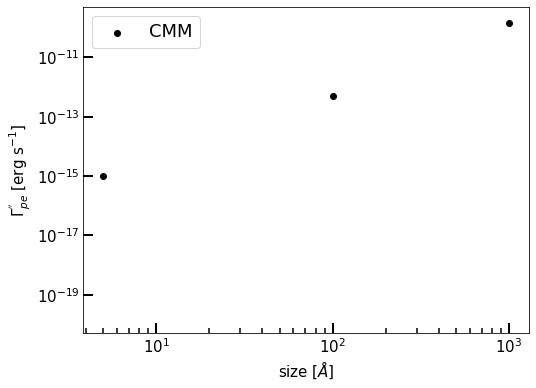

In [44]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

#ax.scatter(GTn, Gammatot)
#ax.scatter([5., 100., 1000.], Gammadot_WNM, c="r", label="WNM")
#ax.scatter([5., 100., 1000.], Gammadot_CNM, c="b", label="CNM")
ax.scatter([5., 100., 1000.], Gammadot_CMM, c="k", label="CMM")

ax.set_yscale("log")
ax.set_xscale("log")
#
ax.set_xlabel("size [$\\AA$]", fontsize=15)
ax.set_ylabel("$\Gamma^{''}_{pe}$ [erg s$^{-1}$]", fontsize=15)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.set_ylim(5.0e-21, 5.0e-10)

ax.legend(loc=0, fontsize=18)

fig.show()

fig.savefig("/Users/juan/Dropbox/Talks/Conf, Workshops & Schools/2018/Group Meeting/HeatingPerGrain_CMM.pdf", format="pdf")